# Final Year Project

## Getting Historical Data

In [ ]:
'''
Code has been adapted from DeepCharts on GitHub (https://github.com/deepcharts/projects/blob/main/Technical_Indicators_For_Machine_Learning.ipynb)

Note:
If you run into issues with pandas_ta:
Install it
!pip install pandas-ta
!pip install numpy==1.25.0
Restart the runtime
'''

In [ ]:
#!pip install pandas_ta
#!pip uninstall pandas_ta numpy tensorflow
!pip install tensorflow
!pip install pandas-ta
!pip install numpy==1.25.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=5de04b99fbee0854ca79a7ec765b9cdf0c5cc7ff6e55039e33d170dd5c59cc5c
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas-ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 98.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.25.0 which is incompatible.
blosc2 3.3.1 requires numpy>=1.26, but you have numpy 1.25.0 which is incompatible.
thinc 8

In [ ]:
import yfinance as yf
import pandas_ta as ta
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [ ]:
# getting the data
'''
import yfinance as yf

full_df = yf.download('^SPX', start="2010-01-01", end="2024-12-31", threads=False)
full_df = full_df[['Open', 'High', 'Low', 'Close', 'Volume']]

full_df.to_csv("/content/drive/MyDrive/FYP/sp500_data_2010_2024.csv")
'''

full_df = pd.read_csv("/content/drive/MyDrive/FYP/sp500_data_2010_2024.csv", parse_dates=['Date'], index_col='Date')

# Convert the index to DatetimeIndex
full_df.index = pd.to_datetime(full_df.index)

full_df

,Open,High,Low,Close,Volume
Date,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,4389590000
...,...,...,...,...,...
2024-12-23,5940.250000,5978.250000,5902.569824,5974.069824,3593280000
2024-12-24,5984.629883,6040.100098,5981.439941,6040.040039,1757720000
2024-12-26,6024.970215,6049.750000,6007.370117,6037.589844,2904530000


In [ ]:
def add_shifted_columns(df_temp):
    df_temp['Previous_Close'] = df_temp['Close'].shift(1) # Prev Day Close Feature
    df_temp['Close_Shifted'] = df_temp['Close'].shift(1) # Prev Day Close Feature
    df_temp['Open_Shifted'] = df_temp['Open'].shift(1)
    df_temp['High_Shifted'] = df_temp['High'].shift(1)
    df_temp['Low_Shifted'] = df_temp['Low'].shift(1)
    return df_temp

def add_indicators(df_temp):
    df_temp = add_shifted_columns(df_temp)
    # Simple Moving Average (SMA): Avg price over last 50 periods
    df_temp['SMA_50'] = ta.sma(df_temp['Close_Shifted'], length=50)

    # Exponential Moving Average (EMA): Weighted average that reacts faster to recent price changes, using 50 periods
    df_temp['EMA_50'] = ta.ema(df_temp['Close_Shifted'], length=50)

    # Relative Strength Index (RSI) : Momentum Indicator that measures the magnitude of recent price changes to evaluate overbought/sold conditions
    df_temp['RSI'] = ta.rsi(df_temp['Close_Shifted'], length=14)

    # Moving Average Convergence Divergence (MACD) : Trend-following momentum indicator: using 12 and 26 periods for fast and slow EMAs and 9-period signal
    macd = ta.macd(df_temp['Close_Shifted'], fast = 12, slow = 26, signal = 9, append=False)
    df_temp['MACD'] = macd['MACD_12_26_9']
    df_temp['Signal_Line'] = macd['MACDs_12_26_9']

    # Bollinger Bands: Volatility indicator using a 20-period moving average and 2 standard deviations
    bollinger = ta.bbands(df_temp['Close_Shifted'], length=20, std=2, append=False)
    df_temp['Upper_Band'] = bollinger['BBU_20_2.0']
    df_temp['Middle_Band'] = bollinger['BBU_20_2.0']
    df_temp['Lower_Band'] = bollinger['BBL_20_2.0']

    # Stochastic Oscillator: Momentum indicator comparing closing pricess to price ranges over 14 periods with a 3-period %D moving average
    stoch = ta.stoch(df_temp['High_Shifted'], df_temp['Low_Shifted'], df_temp['Close_Shifted'], k=14, d=3)
    df_temp['Stoch_K'] = stoch['STOCHk_14_3_3']
    df_temp['Stoch_D'] = stoch['STOCHd_14_3_3']

    # Average True Range (ATR): Measures volatility by averaging true ranges over 14 periods
    df_temp['ATR'] = ta.atr(df_temp['High_Shifted'], df_temp['Low_Shifted'], df_temp['Close_Shifted'], length=14)

    return df_temp.dropna()

# Apply to all sets
full_df= add_indicators(full_df)
full_df = full_df.dropna()

# splitting dataset
df = full_df[full_df.index < "2020-01-01"]
df_test = full_df[full_df.index >= "2020-01-01"]

# Ensure the index is in datetime format
df.index = pd.to_datetime(df.index)
df_test.index = pd.to_datetime(df_test.index)

### Displaying Dataset

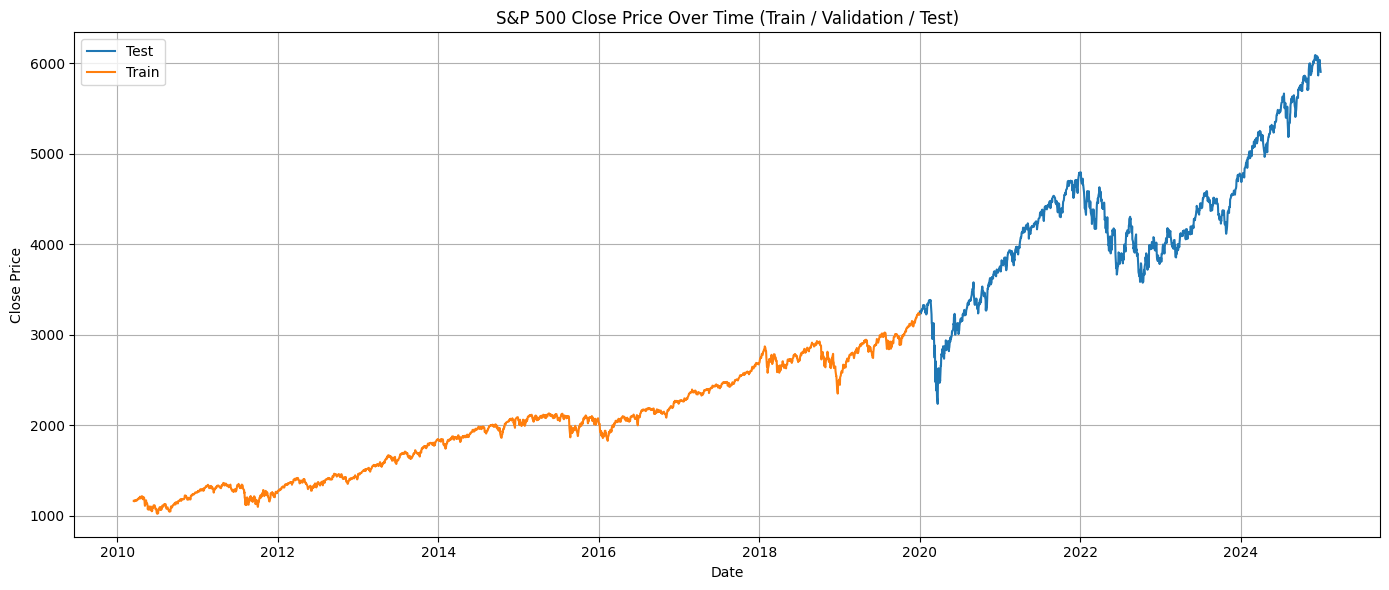

In [ ]:
import matplotlib.pyplot as plt

def plot_actual_close_prices(df_train, df_test):
    # Combine the three datasets
    df_train = df_train.copy()
    df_test = df_test.copy()

    df_train['Set'] = 'Train'
    df_test['Set'] = 'Test'

    full_df = pd.concat([df_train, df_test])

    # Plot
    plt.figure(figsize=(14, 6))
    for label, group in full_df.groupby('Set'):
        plt.plot(group.index, group['Close'], label=label)

    plt.title("S&P 500 Close Price Over Time (Train / Validation / Test)")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_actual_close_prices(df, df_test)

## Modelling

In [ ]:
# parameters
window_size = 20 # 4 weeks of trading days (5 weekdays per week * 4 weeks = 20)

# inclusive of indicators as well as the previous day's closing price
# this provides insight as to the impact of the technical indicators has on the price
indicators = ['SMA_50', 'EMA_50', 'RSI', 'MACD', 'Signal_Line', 'Upper_Band', 'Middle_Band', 'Lower_Band', 'Stoch_K', 'Stoch_D', 'ATR', 'Close_Shifted', 'Previous_Close']

# initializing a dictionary to store predictions, actual and daily MAE
results = {indicator: {'predictions': [], 'actual': [], 'daily_mae': [], 'train_mae': []} for indicator in indicators}

# Flatten MultiIndex column headers, keeping only the first level (e.g., 'SMA_50')

def flatten_column(df):
  if isinstance(df.columns, pd.MultiIndex):
      df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

print(f"Train data length: {len(df)}")
print(f"Test data length: {len(df_test)}")

flatten_column(df)
flatten_column(df_test)

print(df.columns.tolist())
print(df_test.columns.tolist())

Train data length: 2466
Test data length: 1257
['Open', 'High', 'Low', 'Close', 'Volume', 'Previous_Close', 'Close_Shifted', 'Open_Shifted', 'High_Shifted', 'Low_Shifted', 'SMA_50', 'EMA_50', 'RSI', 'MACD', 'Signal_Line', 'Upper_Band', 'Middle_Band', 'Lower_Band', 'Stoch_K', 'Stoch_D', 'ATR']
['Open', 'High', 'Low', 'Close', 'Volume', 'Previous_Close', 'Close_Shifted', 'Open_Shifted', 'High_Shifted', 'Low_Shifted', 'SMA_50', 'EMA_50', 'RSI', 'MACD', 'Signal_Line', 'Upper_Band', 'Middle_Band', 'Lower_Band', 'Stoch_K', 'Stoch_D', 'ATR']


In [ ]:
def normalize_features(df_temp, features):
    scaler = MinMaxScaler()
    df_scaled = df_temp.copy()

    # Fit only on training data
    scaler.fit(df_temp[features])

    # Transform all sets
    df_temp[features] = scaler.transform(df_temp[features])

    return df_scaled

### Experiment 1: LSTM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

def rolling_prediction_lstm(df, window_size, indicators, extra_features=[], forecast_horizon=1, epochs=15, batch_size=64, l2_lambda=0.01, dropout_rate=0.2):
    results = {indicator: {'predictions': [], 'actual': [], 'daily_mae': [], 'train_mae': None, 'test_mae': None, 'loss_history': []}
               for indicator in indicators[:-1]}  # Exclude 'Previous_Close'

    # Define learning rate scheduler for gradual warm-up
    def scheduler(epoch, lr):
        if epoch < 5:
            return 0.0001  # Start with a small learning rate
        else:
            return 0.001  # Increase learning rate after 5 epochs

    lr_scheduler = LearningRateScheduler(scheduler)

    # Early stopping callback
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    for indicator in indicators[:-1]:
        print(f"\nProcessing {indicator}...")

        # Prepare rolling windows
        X_list, y_list, extra_list = [], [], []
        for i in range(window_size, len(df) - forecast_horizon):
            window = df.iloc[i - window_size:i]
            X_list.append(window[[indicator, 'Previous_Close']].values)
            y_list.append(df['Close'].iloc[i + forecast_horizon - 1])

            if extra_features:
                extra_list.append(df[extra_features].iloc[i + forecast_horizon - 1].values)

        X = np.array(X_list)
        y = np.array(y_list)
        if extra_features:
            X_extra = np.array(extra_list)
            X_combined = np.concatenate([X.reshape(X.shape[0], -1), X_extra], axis=1)  # Flatten + concat
        else:
            X_combined = X.reshape(X.shape[0], -1)  # Flatten if no extra features

        # Normalize combined input
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X_combined)

        # Reshape back for LSTM: (samples, time steps, features)
        n_features_total = X.shape[2]
        if extra_features:
            # Inject extra features at the end of time window
            X_scaled = X_scaled.reshape(X.shape[0], window_size, n_features_total + len(extra_features))
        else:
            X_scaled = X_scaled.reshape(X.shape[0], window_size, n_features_total)

        # Normalize the target (Close price)
        scaler_y = MinMaxScaler()
        y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

        # Build LSTM model with 2 layers, 16 neurons, L2 regularization, and dropout
        model = Sequential([
            LSTM(16, return_sequences=True, dropout=dropout_rate, recurrent_dropout=0.3, kernel_regularizer=l2(l2_lambda),
                 input_shape=(X_scaled.shape[1], X_scaled.shape[2])),
            LSTM(16, dropout=dropout_rate, recurrent_dropout=0.3, kernel_regularizer=l2(l2_lambda)),
            Dense(1)
        ])
        model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_absolute_error')

        # Create validation set by splitting the data (keeping the last portion for testing)
        val_size = int(len(X_scaled) * 0.1)  # 10% for validation
        X_train, X_val = X_scaled[:-val_size], X_scaled[-val_size:]
        y_train, y_val = y_scaled[:-val_size], y_scaled[-val_size:]

        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1,
                            validation_data=(X_val, y_val), callbacks=[lr_scheduler, early_stop])

        y_train_pred = model.predict(X_train, verbose=0).flatten()
        y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()
        y_train_rescaled = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
        train_mae = mean_absolute_error(y_train_rescaled, y_train_pred_rescaled)
        results[indicator]['train_mae'] = train_mae
        results[indicator]['loss_history'] = history.history['loss']

        # Rolling prediction
        for j in tqdm(range(window_size, len(df) - forecast_horizon), desc=f"{indicator} Predictions"):
            test_window = df.iloc[j - window_size:j][[indicator, 'Previous_Close']].values
            test_window_flat = test_window.reshape(-1)

            if extra_features:
                extra_vals = df[extra_features].iloc[j + forecast_horizon - 1].values
                test_combined = np.concatenate([test_window_flat, extra_vals])
            else:
                test_combined = test_window_flat

            test_scaled = scaler.transform(test_combined.reshape(1, -1))
            if extra_features:
                test_scaled = test_scaled.reshape(1, window_size, 2 + len(extra_features))
            else:
                test_scaled = test_scaled.reshape(1, window_size, 2)

            scaled_pred = model.predict(test_scaled, verbose=0)[0][0]
            prediction = scaler_y.inverse_transform([[scaled_pred]])[0][0]  # inverse scale
            actual = df['Close'].iloc[j + forecast_horizon - 1]
            daily_mae = abs(actual - prediction)

            results[indicator]['predictions'].append(prediction)
            results[indicator]['actual'].append(actual)
            results[indicator]['daily_mae'].append(daily_mae)

        # Final test MAE
        results[indicator]['test_mae'] = mean_absolute_error(results[indicator]['actual'], results[indicator]['predictions'])

    return results

### Experiment 2: Random Forest

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score

def rolling_prediction(df_segment, window_size, indicators, forecast_horizon=1,
                       n_estimators=15, max_depth=3, extra_features=[], max_features_rf='sqrt'):
    results = {
        indicator: {'predictions': [], 'actual': [], 'daily_mae': [], 'train_mae': []}
        for indicator in indicators[:-1]  # Exclude 'Previous_Close'
    }

    for indicator in indicators[:-1]:
        print(f"Processing indicator: {indicator}")
        progress_bar = tqdm(
            range(window_size, len(df_segment) - forecast_horizon),
            desc=f"{indicator} Progress",
            dynamic_ncols=True
        )

        for i in progress_bar:
            train_df = df_segment.iloc[i - window_size:i]
            test_index = i + forecast_horizon
            if test_index >= len(df_segment):
                break

            train_cols = [indicator, 'Previous_Close'] + extra_features
            X_train = train_df[train_cols]
            y_train = train_df['Close']

            # Drop NaNs
            if X_train.isnull().values.any() or y_train.isnull().any():
                continue

            X_train = sm.add_constant(X_train, has_constant='add')

            # Initialize Random Forest model with updated parameters
            rf_model = RandomForestRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=10,
                min_samples_leaf=5,
                max_features=max_features_rf,
                random_state=42,
                n_jobs=-1
            )

            # Cross-validation to calculate mean MAE
            cross_val_mae = cross_val_score(rf_model, X_train, y_train, cv=3, scoring='neg_mean_absolute_error')
            mean_cv_mae = -cross_val_mae.mean()  # Convert from negative to positive MAE
            results[indicator]['train_mae'].append(mean_cv_mae)

            # Fit model on the entire training set for prediction
            rf_model.fit(X_train, y_train)

            # Prepare test row
            X_test = df_segment[train_cols].iloc[[test_index]]
            if X_test.isnull().values.any():
                continue

            X_test = sm.add_constant(X_test, has_constant='add')
            prediction = rf_model.predict(X_test)[0]
            actual = df_segment['Close'].iloc[test_index]

            results[indicator]['predictions'].append(prediction)
            results[indicator]['actual'].append(actual)
            results[indicator]['daily_mae'].append(abs(actual - prediction))

        # End of each indicator's processing
        print(f"Finished processing {indicator}.")

    return results

### Experiment 3: LSTM+RF

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np
from tqdm import tqdm

def rolling_prediction_stacked(df_segment, window_size, indicators, forecast_horizon=1,
                                epochs=15, batch_size=32, n_estimators=15, max_depth=3,
                                extra_features=[], l2_lambda=0.01, dropout_rate=0.2,
                                max_features_rf='sqrt'):
    results = {indicator: {'predictions': [], 'actual': [], 'daily_mae': [], 'train_mae': []}
               for indicator in indicators[:-1]}  # Exclude 'Previous_Close'

    for indicator in indicators[:-1]:
        print(f"\nProcessing {indicator}...")

        X_list, y_list = [], []
        feature_cols = [indicator, 'Previous_Close'] + extra_features

        for i in range(window_size, len(df_segment) - forecast_horizon):
            window = df_segment.iloc[i - window_size:i]
            if window[feature_cols].isnull().values.any():
                continue
            X_list.append(window[feature_cols].values)
            y_list.append(df_segment['Close'].iloc[i + forecast_horizon - 1])

        X = np.array(X_list)
        y = np.array(y_list)

        # Normalize X
        scaler = MinMaxScaler()
        n_samples, n_steps, n_features = X.shape
        X_flat = X.reshape(n_samples * n_steps, n_features)
        X_scaled_flat = scaler.fit_transform(X_flat)
        X_scaled = X_scaled_flat.reshape(n_samples, n_steps, n_features)

        # Normalize y
        y_scaler = MinMaxScaler()
        y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

        # Stacked LSTM model with 3 layers, 278 neurons, and dropout
        model = Sequential([
            LSTM(278, return_sequences=True, dropout=dropout_rate,
                 recurrent_dropout=0.3, kernel_regularizer=l2(l2_lambda),
                 input_shape=(n_steps, n_features)),
            LSTM(278, return_sequences=True, dropout=dropout_rate,
                 recurrent_dropout=0.3, kernel_regularizer=l2(l2_lambda)),
            LSTM(278, dropout=dropout_rate, recurrent_dropout=0.3,
                 kernel_regularizer=l2(l2_lambda)),
            Dense(1)
        ])
        model.compile(optimizer=Adam(learning_rate=0.000055), loss='mae')

        # Train the model (without early stopping)
        model.fit(X_scaled, y_scaled, epochs=epochs, batch_size=batch_size,
                  validation_split=0.2, verbose=1)

        y_train_pred_scaled = model.predict(X_scaled, verbose=0).flatten()
        y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()

        for j in tqdm(range(window_size, len(df_segment) - forecast_horizon), desc=f"{indicator} Stacked"):
            train_df = df_segment.iloc[j - window_size:j + forecast_horizon]
            if len(train_df) < window_size + forecast_horizon:
                continue
            if train_df[feature_cols].isnull().values.any():
                continue

            # LSTM prediction for the current window
            lstm_input = train_df[feature_cols].iloc[:window_size].values
            lstm_scaled = scaler.transform(lstm_input).reshape(1, window_size, n_features)
            lstm_pred_scaled = model.predict(lstm_scaled, verbose=0).flatten()[0]
            lstm_pred = y_scaler.inverse_transform([[lstm_pred_scaled]])[0][0]

            # Random Forest model prediction
            rf_features = train_df[feature_cols].iloc[window_size + forecast_horizon - 1].values.tolist()
            rf_features.append(lstm_pred)

            rf_train_X = []
            rf_train_y = []
            for k in range(window_size):
                rf_row = train_df[feature_cols].iloc[k].values.tolist()
                idx = j - window_size + k
                if idx >= len(y_train_pred): break
                rf_row.append(y_train_pred[idx])
                rf_train_X.append(rf_row)
                rf_train_y.append(train_df['Close'].iloc[k + forecast_horizon - 1])

            if len(rf_train_X) < 5:
                continue

            # Random Forest Regressor
            rf_model = RandomForestRegressor(
                n_estimators=n_estimators, max_depth=max_depth,
                min_samples_split=10, min_samples_leaf=5,
                max_features=max_features_rf, random_state=5
            )
            rf_model.fit(rf_train_X, rf_train_y)

            rf_train_pred = rf_model.predict(rf_train_X)
            rf_train_mae = mean_absolute_error(rf_train_y, rf_train_pred)

            rf_pred = rf_model.predict([rf_features])[0]
            actual = df_segment['Close'].iloc[j + forecast_horizon - 1]
            daily_mae = abs(actual - rf_pred)

            results[indicator]['predictions'].append(rf_pred)
            results[indicator]['actual'].append(actual)
            results[indicator]['daily_mae'].append(daily_mae)
            results[indicator]['train_mae'].append(rf_train_mae)

    return results

### Training

In [ ]:
import time

# Normalize training and test data
df_norm = normalize_features(df, indicators)
df_test_norm = normalize_features(df_test, indicators)

print(f"Length of df_segment: {len(df)}")
print(f"Window size: {window_size}")

Length of df_segment: 2466
Window size: 20


<ipython-input-6-8752ad576566>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[features] = scaler.transform(df_temp[features])
<ipython-input-6-8752ad576566>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[features] = scaler.transform(df_temp[features])


In [ ]:
# Measure time for RF
start_rf = time.time()
rf_results = rolling_prediction(df_norm, window_size=20, indicators=indicators, extra_features=[])
end_rf = time.time()
rf_time = end_rf - start_rf

Processing indicator: SMA_50


SMA_50 Progress: 100%|██████████| 2445/2445 [08:35<00:00,  4.75it/s]


Finished processing SMA_50.
Processing indicator: EMA_50


EMA_50 Progress: 100%|██████████| 2445/2445 [08:39<00:00,  4.70it/s]


Finished processing EMA_50.
Processing indicator: RSI


RSI Progress: 100%|██████████| 2445/2445 [08:55<00:00,  4.57it/s]


Finished processing RSI.
Processing indicator: MACD


MACD Progress: 100%|██████████| 2445/2445 [08:40<00:00,  4.69it/s]


Finished processing MACD.
Processing indicator: Signal_Line


Signal_Line Progress: 100%|██████████| 2445/2445 [08:37<00:00,  4.72it/s]


Finished processing Signal_Line.
Processing indicator: Upper_Band


Upper_Band Progress: 100%|██████████| 2445/2445 [08:39<00:00,  4.70it/s]


Finished processing Upper_Band.
Processing indicator: Middle_Band


Middle_Band Progress: 100%|██████████| 2445/2445 [08:38<00:00,  4.72it/s]


Finished processing Middle_Band.
Processing indicator: Lower_Band


Lower_Band Progress: 100%|██████████| 2445/2445 [08:33<00:00,  4.76it/s]


Finished processing Lower_Band.
Processing indicator: Stoch_K


Stoch_K Progress: 100%|██████████| 2445/2445 [08:38<00:00,  4.71it/s]


Finished processing Stoch_K.
Processing indicator: Stoch_D


Stoch_D Progress: 100%|██████████| 2445/2445 [08:33<00:00,  4.76it/s]


Finished processing Stoch_D.
Processing indicator: ATR


ATR Progress: 100%|██████████| 2445/2445 [08:32<00:00,  4.77it/s]


Finished processing ATR.
Processing indicator: Close_Shifted


Close_Shifted Progress: 100%|██████████| 2445/2445 [08:32<00:00,  4.77it/s]

Finished processing Close_Shifted.


In [ ]:
# Measure time for LSTM
start_lstm = time.time()
lstm_results = rolling_prediction_lstm(df_norm, window_size=20, indicators=indicators, extra_features=None)
end_lstm = time.time()
lstm_time = end_lstm - start_lstm


Processing SMA_50...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 0.6694 - val_loss: 1.0898 - learning_rate: 1.0000e-04
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.6112 - val_loss: 0.9868 - learning_rate: 1.0000e-04
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.5456 - val_loss: 0.8598 - learning_rate: 1.0000e-04
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.4821 - val_loss: 0.6971 - learning_rate: 1.0000e-04
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.4052 - val_loss: 0.5426 - learning_rate: 1.0000e-04
Epoch 6/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.3437 - val_loss: 0.3314 - learning_rate: 0.0010
Epoch 7/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.2736 - val_loss: 0.2760 - learning_rate: 0.0010
Epoch 8/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.2211 - val_loss: 0.2632 - learning_rate: 0.0010
Epoch 9/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1849 - val_loss: 0.2474 - learning_rate: 0.0010
Epoch 10/

SMA_50 Predictions: 100%|██████████| 2445/2445 [04:34<00:00,  8.92it/s]



Processing EMA_50...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.6264 - val_loss: 0.9126 - learning_rate: 1.0000e-04
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.5388 - val_loss: 0.7619 - learning_rate: 1.0000e-04
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.4588 - val_loss: 0.6030 - learning_rate: 1.0000e-04
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.4141 - val_loss: 0.5215 - learning_rate: 1.0000e-04
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.4073 - val_loss: 0.5083 - learning_rate: 1.0000e-04
Epoch 6/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.3681 - val_loss: 0.4020 - learning_rate: 0.0010
Epoch 7/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.2894 - val_loss: 0.3599 - learning_rate: 0.0010
Epoch 8/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.2379 - val_loss: 0.3021 - learning_rate: 0.0010
Epoch 9/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1976 - val_loss: 0.2499 - learning_rate: 0.0010
Epoch 10/1

EMA_50 Predictions: 100%|██████████| 2445/2445 [04:29<00:00,  9.06it/s]



Processing RSI...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 0.9335 - val_loss: 1.4382 - learning_rate: 1.0000e-04
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.8136 - val_loss: 1.2969 - learning_rate: 1.0000e-04
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.7063 - val_loss: 1.1622 - learning_rate: 1.0000e-04
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.6177 - val_loss: 1.0279 - learning_rate: 1.0000e-04
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.5428 - val_loss: 0.9004 - learning_rate: 1.0000e-04
Epoch 6/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.4425 - val_loss: 0.5033 - learning_rate: 0.0010
Epoch 7/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.3230 - val_loss: 0.3869 - learning_rate: 0.0010
Epoch 8/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.2637 - val_loss: 0.3251 - learning_rate: 0.0010
Epoch 9/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.2249 - val_loss: 0.2600 - learning_rate: 0.0010
Epoch 10/

RSI Predictions: 100%|██████████| 2445/2445 [04:28<00:00,  9.12it/s]



Processing MACD...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.6233 - val_loss: 1.0080 - learning_rate: 1.0000e-04
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.5652 - val_loss: 0.9085 - learning_rate: 1.0000e-04
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.5111 - val_loss: 0.8056 - learning_rate: 1.0000e-04
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.4706 - val_loss: 0.7064 - learning_rate: 1.0000e-04
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.4441 - val_loss: 0.6370 - learning_rate: 1.0000e-04
Epoch 6/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.3872 - val_loss: 0.3758 - learning_rate: 0.0010
Epoch 7/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.2964 - val_loss: 0.3583 - learning_rate: 0.0010
Epoch 8/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.2414 - val_loss: 0.2794 - learning_rate: 0.0010
Epoch 9/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.2074 - val_loss: 0.2410 - learning_rate: 0.0010
Epoch 10/1

MACD Predictions: 100%|██████████| 2445/2445 [04:25<00:00,  9.22it/s]



Processing Signal_Line...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - loss: 0.6724 - val_loss: 1.0048 - learning_rate: 1.0000e-04
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.5664 - val_loss: 0.8484 - learning_rate: 1.0000e-04
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.5021 - val_loss: 0.7075 - learning_rate: 1.0000e-04
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.4626 - val_loss: 0.6208 - learning_rate: 1.0000e-04
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.4356 - val_loss: 0.5789 - learning_rate: 1.0000e-04
Epoch 6/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.3970 - val_loss: 0.4078 - learning_rate: 0.0010
Epoch 7/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.3015 - val_loss: 0.3510 - learning_rate: 0.0010
Epoch 8/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.2603 - val_loss: 0.3320 - learning_rate: 0.0010
Epoch 9/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.2330 - val_loss: 0.2798 - learning_rate: 0.0010
Epoch 10/

Signal_Line Predictions: 100%|██████████| 2445/2445 [04:46<00:00,  8.53it/s]



Processing Upper_Band...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.6410 - val_loss: 0.9347 - learning_rate: 1.0000e-04
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.5370 - val_loss: 0.7300 - learning_rate: 1.0000e-04
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.4409 - val_loss: 0.5429 - learning_rate: 1.0000e-04
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.4022 - val_loss: 0.4619 - learning_rate: 1.0000e-04
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.3946 - val_loss: 0.4615 - learning_rate: 1.0000e-04
Epoch 6/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.3610 - val_loss: 0.3529 - learning_rate: 0.0010
Epoch 7/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.2833 - val_loss: 0.3057 - learning_rate: 0.0010
Epoch 8/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.2382 - val_loss: 0.2914 - learning_rate: 0.0010
Epoch 9/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.2010 - val_loss: 0.2813 - learning_rate: 0.0010
Epoch 10

Upper_Band Predictions: 100%|██████████| 2445/2445 [04:40<00:00,  8.72it/s]



Processing Middle_Band...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 0.8061 - val_loss: 1.2953 - learning_rate: 1.0000e-04
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.7178 - val_loss: 1.1687 - learning_rate: 1.0000e-04
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.6309 - val_loss: 1.0396 - learning_rate: 1.0000e-04
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.5461 - val_loss: 0.8980 - learning_rate: 1.0000e-04
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.4781 - val_loss: 0.7454 - learning_rate: 1.0000e-04
Epoch 6/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.3904 - val_loss: 0.3774 - learning_rate: 0.0010
Epoch 7/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.2881 - val_loss: 0.3400 - learning_rate: 0.0010
Epoch 8/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.2437 - val_loss: 0.2933 - learning_rate: 0.0010
Epoch 9/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.2057 - val_loss: 0.2940 - learning_rate: 0.0010
Epoch 10/

Middle_Band Predictions: 100%|██████████| 2445/2445 [04:34<00:00,  8.92it/s]



Processing Lower_Band...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 0.6837 - val_loss: 0.9987 - learning_rate: 1.0000e-04
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.5502 - val_loss: 0.7859 - learning_rate: 1.0000e-04
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.4669 - val_loss: 0.6286 - learning_rate: 1.0000e-04
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.4434 - val_loss: 0.5590 - learning_rate: 1.0000e-04
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.4239 - val_loss: 0.5318 - learning_rate: 1.0000e-04
Epoch 6/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.3674 - val_loss: 0.3835 - learning_rate: 0.0010
Epoch 7/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.2842 - val_loss: 0.3610 - learning_rate: 0.0010
Epoch 8/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.2357 - val_loss: 0.2956 - learning_rate: 0.0010
Epoch 9/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1952 - val_loss: 0.2915 - learning_rate: 0.0010
Epoch 10/

Lower_Band Predictions: 100%|██████████| 2445/2445 [04:29<00:00,  9.06it/s]



Processing Stoch_K...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 0.6449 - val_loss: 1.0066 - learning_rate: 1.0000e-04
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.5728 - val_loss: 0.8931 - learning_rate: 1.0000e-04
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.5070 - val_loss: 0.7844 - learning_rate: 1.0000e-04
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.4727 - val_loss: 0.6886 - learning_rate: 1.0000e-04
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.4476 - val_loss: 0.6330 - learning_rate: 1.0000e-04
Epoch 6/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.4116 - val_loss: 0.4755 - learning_rate: 0.0010
Epoch 7/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.3157 - val_loss: 0.3728 - learning_rate: 0.0010
Epoch 8/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.2571 - val_loss: 0.3178 - learning_rate: 0.0010
Epoch 9/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.2180 - val_loss: 0.2899 - learning_rate: 0.0010
Epoch 10/

Stoch_K Predictions: 100%|██████████| 2445/2445 [04:32<00:00,  8.99it/s]



Processing Stoch_D...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.6315 - val_loss: 0.9712 - learning_rate: 1.0000e-04
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.5567 - val_loss: 0.8702 - learning_rate: 1.0000e-04
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.5104 - val_loss: 0.7754 - learning_rate: 1.0000e-04
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.4747 - val_loss: 0.6976 - learning_rate: 1.0000e-04
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.4449 - val_loss: 0.6493 - learning_rate: 1.0000e-04
Epoch 6/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.4044 - val_loss: 0.4321 - learning_rate: 0.0010
Epoch 7/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.3189 - val_loss: 0.3476 - learning_rate: 0.0010
Epoch 8/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.2584 - val_loss: 0.3011 - learning_rate: 0.0010
Epoch 9/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.2218 - val_loss: 0.2765 - learning_rate: 0.0010
Epoch 10/

Stoch_D Predictions: 100%|██████████| 2445/2445 [04:33<00:00,  8.95it/s]



Processing ATR...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 0.6567 - val_loss: 1.0118 - learning_rate: 1.0000e-04
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.5614 - val_loss: 0.8551 - learning_rate: 1.0000e-04
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.4862 - val_loss: 0.6731 - learning_rate: 1.0000e-04
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.4274 - val_loss: 0.5792 - learning_rate: 1.0000e-04
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.4154 - val_loss: 0.5639 - learning_rate: 1.0000e-04
Epoch 6/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.3674 - val_loss: 0.4186 - learning_rate: 0.0010
Epoch 7/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.3060 - val_loss: 0.3876 - learning_rate: 0.0010
Epoch 8/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.2461 - val_loss: 0.3118 - learning_rate: 0.0010
Epoch 9/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.2104 - val_loss: 0.2559 - learning_rate: 0.0010
Epoch 10/

ATR Predictions: 100%|██████████| 2445/2445 [04:39<00:00,  8.74it/s]



Processing Close_Shifted...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - loss: 0.6100 - val_loss: 0.9299 - learning_rate: 1.0000e-04
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.5354 - val_loss: 0.8000 - learning_rate: 1.0000e-04
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.4670 - val_loss: 0.6485 - learning_rate: 1.0000e-04
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.4146 - val_loss: 0.5494 - learning_rate: 1.0000e-04
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.4013 - val_loss: 0.5070 - learning_rate: 1.0000e-04
Epoch 6/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.3602 - val_loss: 0.3943 - learning_rate: 0.0010
Epoch 7/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.2887 - val_loss: 0.2987 - learning_rate: 0.0010
Epoch 8/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.2441 - val_loss: 0.3138 - learning_rate: 0.0010
Epoch 9/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1900 - val_loss: 0.2880 - learning_rate: 0.0010
Epoch 10/

Close_Shifted Predictions: 100%|██████████| 2445/2445 [04:36<00:00,  8.84it/s]


In [ ]:
# Measure time for Stacked (LSTM + RF)
start_stacked = time.time()
stacked_results = rolling_prediction_stacked(df_norm, window_size=20, indicators=indicators, extra_features=[])
end_stacked = time.time()
stacked_time = end_stacked - start_stacked

In [ ]:
import pickle

print("Execution Time (in seconds):")
print(f"Random Forest (RF):        {rf_time:.2f} s")
print(f"LSTM:                       {lstm_time:.2f} s")
#print(f"Stacked Model (LSTM + RF): {stacked_time:.2f} s")

## saving the trained model:
import pickle

# Save stacked_results to a file
with open('/content/drive/MyDrive/FYP/output/stacked_results.pkl', 'wb') as f:
    pickle.dump(stacked_results, f)

with open('/content/drive/MyDrive/FYP/output/lstm_results.pkl', 'wb') as f:
    pickle.dump(lstm_results, f)

with open('/content/drive/MyDrive/FYP/output/rf_results.pkl', 'wb') as f:
    pickle.dump(rf_results, f)

Execution Time (in seconds):
Random Forest (RF):        6218.99 s
LSTM:                       3709.60 s


## Outputting Results

In [ ]:
import pickle
import pandas as pd
import numpy as np

# Load results from pickle files
with open('/content/drive/MyDrive/FYP/output/lstm_results.pkl', 'rb') as f:
    lstm_results = pickle.load(f)

with open('/content/drive/MyDrive/FYP/output/rf_results.pkl', 'rb') as f:
    rf_results = pickle.load(f)

with open('/content/drive/MyDrive/FYP/output/stacked_results.pkl', 'rb') as f:
     stacked_results = pickle.load(f)

def summarize_mae(results, name="Model"):
    rows = []
    for ind in results:
        train_mae = np.mean(results[ind]['train_mae'])
        test_mae = np.mean(results[ind]['daily_mae'])
        rows.append([ind, train_mae, test_mae])
    df_summary = pd.DataFrame(rows, columns=["Indicator", f"{name}_Train_MAE", f"{name}_Test_MAE"])
    return df_summary

df_rf = summarize_mae(rf_results, "RF")
df_lstm = summarize_mae(lstm_results, "LSTM")
df_stack = summarize_mae(stacked_results, "RF+LSTM")

comparison_df = df_rf.merge(df_lstm, on="Indicator").merge(df_stack, on="Indicator")


print(comparison_df.round(4))


        Indicator  RF_Train_MAE  RF_Test_MAE  LSTM_Train_MAE  LSTM_Test_MAE  \
0          SMA_50       26.6741      23.9319        139.0159       163.9414   
1          EMA_50       26.7516      24.3913        165.9978       188.9167   
2             RSI       26.2023      22.6558        178.3408       196.6710   
3            MACD       26.5725      23.3039        160.9871       177.3852   
4     Signal_Line       26.8370      24.7627        170.0857       187.2222   
5      Upper_Band       26.8196      24.4806        128.9609       152.8971   
6     Middle_Band       26.8196      24.4806        100.1030       124.9668   
7      Lower_Band       26.8379      25.0127        141.4331       164.5916   
8         Stoch_K       26.5097      24.6186        165.0057       181.0949   
9         Stoch_D       26.6419      24.8987        158.1347       174.4297   
10            ATR       26.7875      24.3737        157.3346       172.2084   
11  Close_Shifted       26.0293      21.0107        

In [ ]:
# Sort by Test MAE to find the best indicators (lowest test MAE)
best_indicators_test = comparison_df.sort_values(by=["RF+LSTM_Test_MAE", "LSTM_Test_MAE", "RF_Test_MAE"]).reset_index(drop=True)

# Get top 3 indicators based on Test MAE
top_3_indicators_test = best_indicators_test.head(3)

# Display the top 3 indicators
print("Top 3 best indicators based on Test MAE:")
print(top_3_indicators_test.round(4))

Top 3 best indicators based on Test MAE:
       Indicator  RF_Train_MAE  RF_Test_MAE  LSTM_Train_MAE  LSTM_Test_MAE  \
0  Close_Shifted       26.0293      21.0107        159.5817       184.2723   
1            RSI       26.2023      22.6558        178.3408       196.6710   
2           MACD       26.5725      23.3039        160.9871       177.3852   

   RF+LSTM_Train_MAE  RF+LSTM_Test_MAE  
0            11.8803           22.8239  
1            11.8901           23.1665  
2            12.2029           23.2293  


In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(lstm_results):
    """
    Plot loss curves for each indicator from LSTM training.

    Parameters:
    - lstm_results: dict containing 'loss_history' for each indicator
    """
    plt.figure(figsize=(12, 8))

    for indicator, data in lstm_results.items():
        if 'loss_history' in data and data['loss_history']:
            plt.plot(data['loss_history'], label=indicator)

    plt.title("LSTM Training Loss Curve per Indicator")
    plt.xlabel("Epochs")
    plt.ylabel("MAE Loss")
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

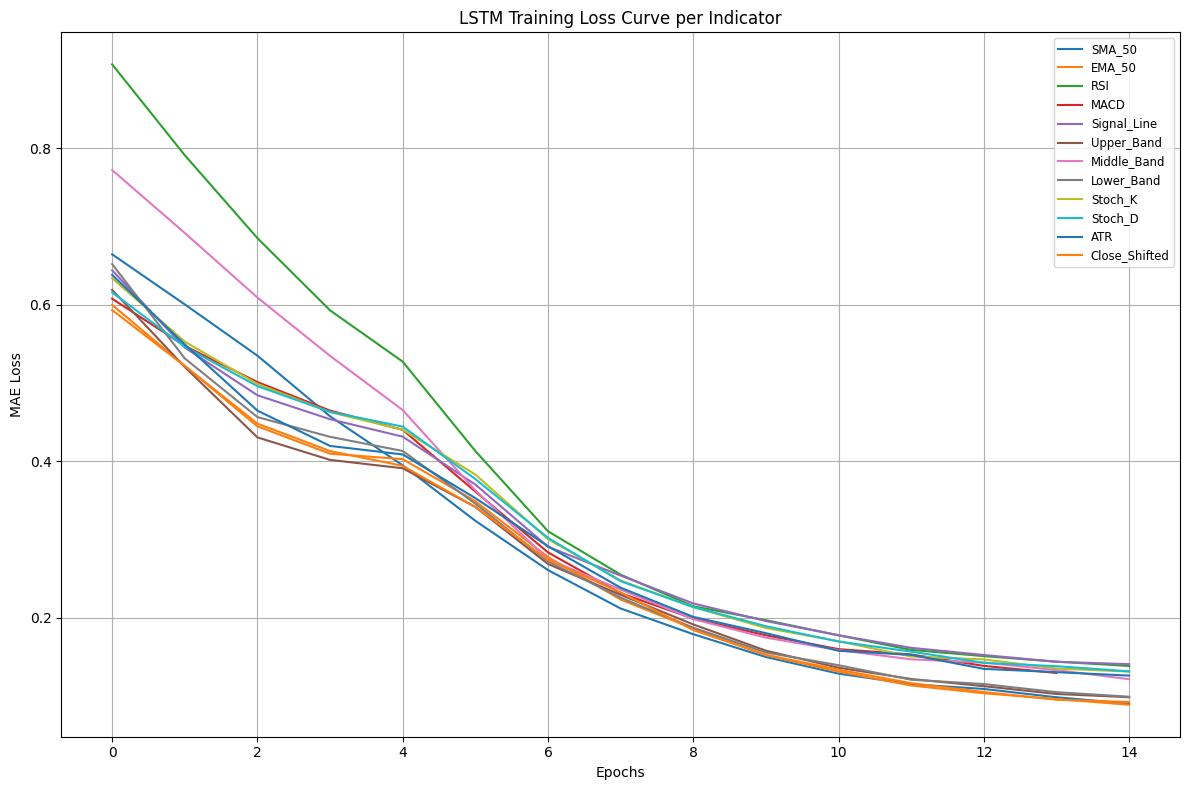

In [ ]:
plot_loss_curves(lstm_results)

### Plotting Model

Top 3 RF indicators: ['Close_Shifted', 'RSI', 'MACD']
Top 3 LSTM indicators: ['MACD', 'Close_Shifted', 'RSI']
Top 3 RF+LSTM indicators: ['Close_Shifted', 'RSI', 'MACD']


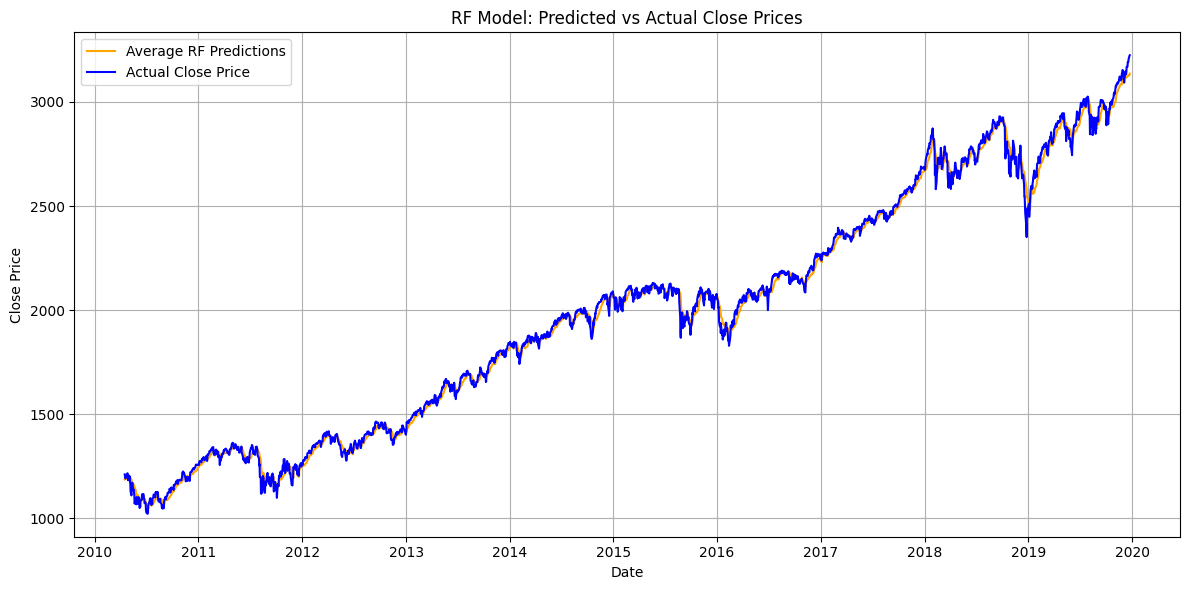

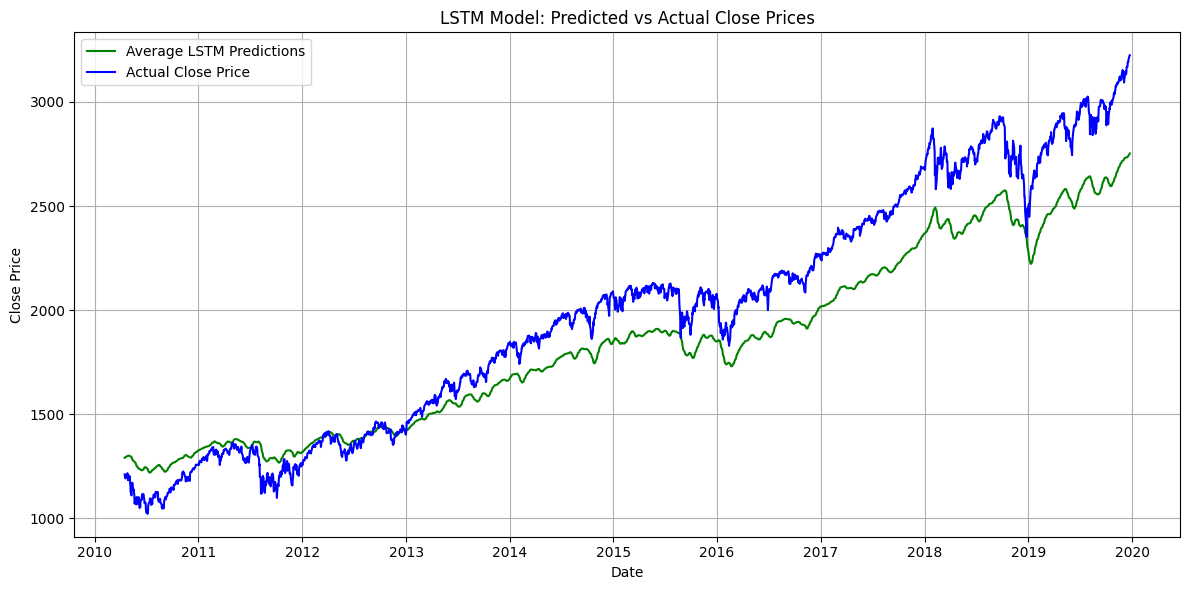

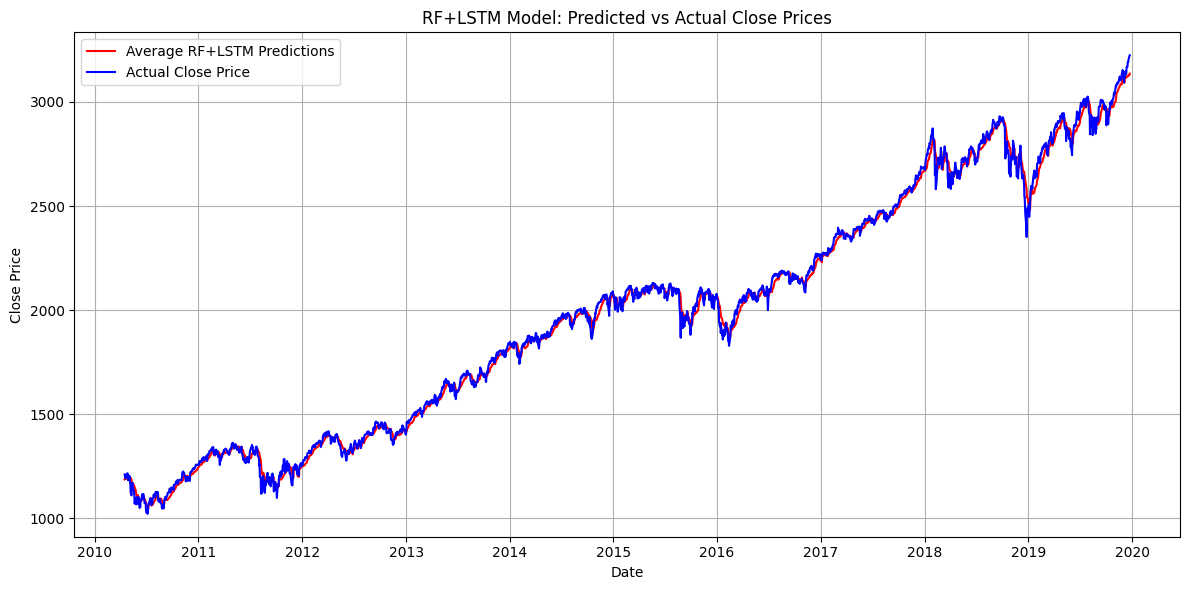

In [ ]:
avg_preds_rf = []
avg_preds_lstm = []
avg_preds_rf_lstm = []
actual_prices = []

mae_scores_rf = {}
mae_scores_lstm = {}
mae_scores_rf_lstm = {}

# Step 1: Calculate MAE scores per model
for indicator in top_3_indicators_test['Indicator']:
    rf_preds = stacked_results[indicator]['predictions']
    rf_actuals = stacked_results[indicator]['actual']
    mae_scores_rf[indicator] = mean_absolute_error(rf_actuals, rf_preds)

    lstm_preds = lstm_results[indicator]['predictions']
    lstm_actuals = lstm_results[indicator]['actual']
    mae_scores_lstm[indicator] = mean_absolute_error(lstm_actuals, lstm_preds)

    rf_lstm_preds = stacked_results[indicator]['predictions']
    rf_lstm_actuals = stacked_results[indicator]['actual']
    mae_scores_rf_lstm[indicator] = mean_absolute_error(rf_lstm_actuals, rf_lstm_preds)

# Step 2: Select top 3 indicators
top_3_rf = sorted(mae_scores_rf, key=mae_scores_rf.get)[:3]
top_3_lstm = sorted(mae_scores_lstm, key=mae_scores_lstm.get)[:3]
top_3_rf_lstm = sorted(mae_scores_rf_lstm, key=mae_scores_rf_lstm.get)[:3]

print("Top 3 RF indicators:", top_3_rf)
print("Top 3 LSTM indicators:", top_3_lstm)
print("Top 3 RF+LSTM indicators:", top_3_rf_lstm)

# Step 3: Find minimum common prediction length
min_len = min(
    len(stacked_results[top_3_rf[0]]['predictions']),
    *[len(lstm_results[ind]['predictions']) for ind in top_3_lstm],
    *[len(stacked_results[ind]['predictions']) for ind in top_3_rf_lstm]
)

# Step 4: Average predictions
for i in range(min_len):
    avg_preds_rf.append(np.mean([stacked_results[ind]['predictions'][i] for ind in top_3_rf]))
    avg_preds_lstm.append(np.mean([lstm_results[ind]['predictions'][i] for ind in top_3_lstm]))
    avg_preds_rf_lstm.append(np.mean([stacked_results[ind]['predictions'][i] for ind in top_3_rf_lstm]))
    actual_prices.append(stacked_results[top_3_rf[0]]['actual'][i])

# Step 5: Define aligned test dates
test_dates = df_norm.index[window_size + 1: window_size + 1 + min_len]

# Plot 1: RF
plt.figure(figsize=(12, 6))
plt.plot(test_dates, avg_preds_rf, label='Average RF Predictions', color='orange')
plt.plot(test_dates, actual_prices, label='Actual Close Price', color='blue')
plt.title("RF Model: Predicted vs Actual Close Prices")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: LSTM
plt.figure(figsize=(12, 6))
plt.plot(test_dates, avg_preds_lstm, label='Average LSTM Predictions', color='green')
plt.plot(test_dates, actual_prices, label='Actual Close Price', color='blue')
plt.title("LSTM Model: Predicted vs Actual Close Prices")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: RF+LSTM
plt.figure(figsize=(12, 6))
plt.plot(test_dates, avg_preds_rf_lstm, label='Average RF+LSTM Predictions', color='red')
plt.plot(test_dates, actual_prices, label='Actual Close Price', color='blue')
plt.title("RF+LSTM Model: Predicted vs Actual Close Prices")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Model Evaluation

In [ ]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_direction_classification(y_true_prices, y_pred_prices):
    y_true_class = np.where(np.diff(y_true_prices, prepend=y_true_prices[0]) > 0, 1, 0)
    y_pred_class = np.where(np.diff(y_pred_prices, prepend=y_pred_prices[0]) > 0, 1, 0)

    return {
        'Accuracy': accuracy_score(y_true_class, y_pred_class),
        'Precision': precision_score(y_true_class, y_pred_class),
        'Recall': recall_score(y_true_class, y_pred_class),
        'F1 Score': f1_score(y_true_class, y_pred_class)
    }

def evaluate_model_to_classification_table(path, model_name):
    with open(path, 'rb') as f:
        results = pickle.load(f)

    rows = []

    for indicator, data in results.items():
        y_true = np.array(data['actual'])
        y_pred = np.array(data['predictions'])

        # Classification metrics
        classification = evaluate_direction_classification(y_true, y_pred)

        row = {
            'Model': model_name,
            'Indicator': indicator,
            'Accuracy': classification['Accuracy'],
            'Precision': classification['Precision'],
            'Recall': classification['Recall'],
            'F1 Score': classification['F1 Score']
        }
        rows.append(row)

    return pd.DataFrame(rows)

# 📂 Paths to model result files
paths = {
    'Stacked': '/content/drive/MyDrive/FYP/output/stacked_results.pkl',
    'LSTM': '/content/drive/MyDrive/FYP/output/lstm_results.pkl',
    'Random Forest': '/content/drive/MyDrive/FYP/output/rf_results.pkl'
}

# 📊 Combine all model results into one table
all_results_df = pd.concat([
    evaluate_model_to_classification_table(path, model_name)
    for model_name, path in paths.items()
], ignore_index=True)

# 📉 Calculate averages for each model (across indicators)
averages_df = all_results_df.groupby('Model').agg({
    'Accuracy': 'mean',
    'Precision': 'mean',
    'Recall': 'mean',
    'F1 Score': 'mean'
}).reset_index()

# 🖨️ Display the full results with averages
pd.set_option('display.max_columns', None)
print(averages_df.round(4))

           Model  Accuracy  Precision  Recall  F1 Score
0           LSTM    0.5071     0.5394  0.6535    0.5906
1  Random Forest    0.4996     0.5359  0.6136    0.5721
2        Stacked    0.5001     0.5360  0.6138    0.5723


## Sentiment Analysis

To see how social media dataset was collected + how to generate sentiment scores, see: SentimentAnalysis.ipynb

## Adding Sentiment Analysis to Dataset

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import MinMaxScaler

# Load your SP500 dataset
#df = pd.read_csv("/content/drive/MyDrive/FYP/sp500_data_2010_2024.csv")

# Reset the index to make 'Date' a column before merging
df_reset = df.reset_index()

# Load the sentiment data files
daily_sentiment_audio_df = pd.read_csv("/content/drive/MyDrive/FYP/daily_sentiment_scores_w_audio.csv")
daily_sentiment_df = pd.read_csv("/content/drive/MyDrive/FYP/daily_sentiment_scores.csv")

# Ensure the sentiment data is sorted by date
daily_sentiment_audio_df['Date'] = pd.to_datetime(daily_sentiment_audio_df['Date'])
daily_sentiment_df['Date'] = pd.to_datetime(daily_sentiment_df['Date'])

# Merge the sentiment data with the stock data (df)
df_merged = pd.merge(df_reset, daily_sentiment_audio_df[['Date', 'Daily Sentiment Score (w/ Audio)']], on='Date', how='left')
df_merged = pd.merge(df_merged, daily_sentiment_df[['Date', 'Daily Sentiment Score']], on='Date', how='left')

# Check the result
print(df_merged.columns)

# Assuming comparison_df contains your indicator comparison results
best_indicators_test = comparison_df.sort_values(by=["RF+LSTM_Test_MAE", "LSTM_Test_MAE", "RF_Test_MAE"]).reset_index(drop=True)

# Get the top 3 best indicators based on Test MAE
top_3_indicators_test = best_indicators_test.head(3)

print("Top 3 best indicators based on Test MAE:")
print(top_3_indicators_test.round(4))

top_3_indicators = top_3_indicators_test['Indicator'].tolist()

# Helper function to normalize features
def normalize_features(df_temp, features):
    scaler = MinMaxScaler()
    df_scaled = df_temp.copy()
    scaler.fit(df_temp[features])
    df_temp[features] = scaler.transform(df_temp[features])
    return df_scaled

# Forward and back fill only the two sentiment score columns
df_sentiment = df_merged.copy()
df_sentiment[['Daily Sentiment Score', 'Daily Sentiment Score (w/ Audio)']] = df_sentiment[
    ['Daily Sentiment Score', 'Daily Sentiment Score (w/ Audio)']
].ffill().bfill()

# Feature Set 1: Include 'sentiment_audio'
indicators_with_audio = top_3_indicators + ['Daily Sentiment Score (w/ Audio)']
df_norm_audio = normalize_features(df_sentiment, indicators_with_audio)

# Feature Set 2: Exclude 'sentiment_audio'
indicators_without_audio = top_3_indicators + ['Daily Sentiment Score']
df_norm_no_audio = normalize_features(df_sentiment, indicators_without_audio)

# Function to train the RF+LSTM stacked model
def train_rf_lstm_stacked_model(df_norm, indicators, extra_features):
    start_stacked = time.time()

    # Pass the normalized data, selected indicators, and extra features
    stacked_results = rolling_prediction_stacked(
      df_segment=df_norm,  # Corrected to use df_norm
      window_size=20,
      indicators=indicators + ['Previous_Close'],  # Ensure you're passing the correct indicators
      forecast_horizon=1,
      extra_features=extra_features
    )

    end_stacked = time.time()

    stacked_time = end_stacked - start_stacked
    print(f"Time taken for stacked model with {', '.join(indicators)}: {stacked_time} seconds")
    return stacked_results

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Previous_Close',
       'Close_Shifted', 'Open_Shifted', 'High_Shifted', 'Low_Shifted',
       'SMA_50', 'EMA_50', 'RSI', 'MACD', 'Signal_Line', 'Upper_Band',
       'Middle_Band', 'Lower_Band', 'Stoch_K', 'Stoch_D', 'ATR',
       'Daily Sentiment Score (w/ Audio)', 'Daily Sentiment Score'],
      dtype='object')
Top 3 best indicators based on Test MAE:
       Indicator  RF_Train_MAE  RF_Test_MAE  LSTM_Train_MAE  LSTM_Test_MAE  \
0  Close_Shifted       26.0293      21.0107        159.5817       184.2723   
1            RSI       26.2023      22.6558        178.3408       196.6710   
2           MACD       26.5725      23.3039        160.9871       177.3852   

   RF+LSTM_Train_MAE  RF+LSTM_Test_MAE  
0            11.8803           22.8239  
1            11.8901           23.1665  
2            12.2029           23.2293  


### Training with Sentiment Analysis

In [ ]:
# Train the model without the sentiment_audio feature
stacked_results_no_audio = train_rf_lstm_stacked_model(df_norm_no_audio, indicators_without_audio, ['Daily Sentiment Score'])
print("Stacked model results without sentiment audio:")
print(stacked_results_no_audio)


Processing Close_Shifted...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 55s 689ms/step - loss: 8.8418 - val_loss: 7.8918
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 668ms/step - loss: 7.5707 - val_loss: 6.8912
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 686ms/step - loss: 6.5466 - val_loss: 5.9453
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 81s 666ms/step - loss: 5.6502 - val_loss: 5.1399
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 82s 661ms/step - loss: 4.8669 - val_loss: 4.4253
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 664ms/step - loss: 4.1854 - val_loss: 3.7899
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 662ms/step - loss: 3.5986 - val_loss: 3.2953
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 655ms/step - loss: 3.0847 - val_loss: 2.8636
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 40s 645ms/step - loss: 2.6370 - val_loss: 2.4572
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 43s 674ms/step - loss: 2.2593 - val_loss: 2.0941
Epoch 11/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 673ms/step - loss: 1.9246 - val_loss: 1.8049
Epoch 12/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 42

Close_Shifted Stacked: 100%|██████████| 2445/2445 [09:55<00:00,  4.11it/s]



Processing RSI...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 54s 687ms/step - loss: 8.8182 - val_loss: 7.9119
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 80s 662ms/step - loss: 7.5585 - val_loss: 6.8872
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 662ms/step - loss: 6.5376 - val_loss: 5.9534
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 662ms/step - loss: 5.6499 - val_loss: 5.1429
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 82s 664ms/step - loss: 4.8705 - val_loss: 4.4377
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 81s 637ms/step - loss: 4.1930 - val_loss: 3.8507
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 641ms/step - loss: 3.6047 - val_loss: 3.2668
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 650ms/step - loss: 3.0976 - val_loss: 2.7961
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 647ms/step - loss: 2.6590 - val_loss: 2.4425
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 665ms/step - loss: 2.2751 - val_loss: 2.1330
Epoch 11/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 40s 646ms/step - loss: 1.9467 - val_loss: 1.8107
Epoch 12/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 42

RSI Stacked: 100%|██████████| 2445/2445 [09:55<00:00,  4.11it/s]



Processing MACD...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 54s 683ms/step - loss: 8.8939 - val_loss: 8.0393
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 80s 650ms/step - loss: 7.6272 - val_loss: 6.9271
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 660ms/step - loss: 6.5923 - val_loss: 6.0078
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 40s 651ms/step - loss: 5.7073 - val_loss: 5.2061
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 661ms/step - loss: 4.9233 - val_loss: 4.4791
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 40s 645ms/step - loss: 4.2430 - val_loss: 3.8698
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 679ms/step - loss: 3.6534 - val_loss: 3.3102
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 80s 644ms/step - loss: 3.1327 - val_loss: 2.8639
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 649ms/step - loss: 2.6894 - val_loss: 2.4902
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 682ms/step - loss: 2.3113 - val_loss: 2.1192
Epoch 11/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 80s 656ms/step - loss: 1.9822 - val_loss: 1.8182
Epoch 12/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 40

MACD Stacked: 100%|██████████| 2445/2445 [10:11<00:00,  4.00it/s]



Processing Daily Sentiment Score...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 56s 693ms/step - loss: 8.8923 - val_loss: 8.0265
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 81s 680ms/step - loss: 7.6170 - val_loss: 6.9144
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 81s 668ms/step - loss: 6.6031 - val_loss: 6.0251
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 82s 662ms/step - loss: 5.7095 - val_loss: 5.2055
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 662ms/step - loss: 4.9282 - val_loss: 4.4936
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 663ms/step - loss: 4.2479 - val_loss: 3.8370
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 82s 664ms/step - loss: 3.6574 - val_loss: 3.3625
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 80s 634ms/step - loss: 3.1483 - val_loss: 2.8759
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 40s 624ms/step - loss: 2.7071 - val_loss: 2.4877
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 40s 643ms/step - loss: 2.3214 - val_loss: 2.1426
Epoch 11/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 663ms/step - loss: 1.9850 - val_loss: 1.8274
Epoch 12/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 80

Daily Sentiment Score Stacked: 100%|██████████| 2445/2445 [10:01<00:00,  4.06it/s]

Time taken for stacked model with Close_Shifted, RSI, MACD, Daily Sentiment Score: 5777.923219919205 seconds
Stacked model results without sentiment audio:
{'Close_Shifted': {'predictions': [1183.6518675789002, 1186.7045547432622, 1186.6422657280461, 1189.4135882873004, 1192.5409793707902, 1195.5761408058765, 1197.6052168618598, 1202.2301676506363, 1205.4063884816037, 1184.4564701528398, 1197.2779115446772, 1200.5510676985323, 1192.0135754092146, 1201.2214831209865, 1195.3691659389287, 1195.5079116758395, 1186.1291893280602, 1183.5610375981983, 1181.1925470779854, 1165.8198737048767, 1175.9210679025023, 1166.8744207473028, 1172.4202239411884, 1171.4604350414397, 1162.2001734745966, 1156.5678934289995, 1147.0981238170784, 1142.4018067182203, 1125.7252023386454, 1117.4095393129096, 1112.6571535024898, 1098.9854288324389, 1101.9978983070243, 1095.6796255975876, 1095.0719357140931, 1092.986895470117, 1084.0737295470915, 1087.6222645970656, 1090.276092290278, 1086.272787134966, 1083.1618149

In [ ]:
# Train the model with the sentiment_audio feature
stacked_results_audio = train_rf_lstm_stacked_model(df_norm_audio, indicators_with_audio, ['Daily Sentiment Score (w/ Audio)'])
print("Stacked model results with sentiment audio:")
print(stacked_results_audio)


Processing Close_Shifted...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - loss: 8.8661 - val_loss: 7.9418
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - loss: 7.5770 - val_loss: 6.8475
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - loss: 6.5403 - val_loss: 5.9383
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - loss: 5.6305 - val_loss: 5.1044
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - loss: 4.8411 - val_loss: 4.4028
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - loss: 4.1565 - val_loss: 3.7942
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - loss: 3.5567 - val_loss: 3.2452
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - loss: 3.0466 - val_loss: 2.7881
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - loss: 2.5947 - val_loss: 2.3801
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - loss: 2.2130 - val_loss: 2.0582
Epoch 11/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - loss: 1.8782 - val_loss: 1.7702
Epoch 12/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - loss: 1

Close_Shifted Stacked: 100%|██████████| 2445/2445 [04:35<00:00,  8.88it/s]



Processing RSI...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - loss: 8.8554 - val_loss: 7.9770
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - loss: 7.5810 - val_loss: 6.8635
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - loss: 6.5488 - val_loss: 5.9885
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - loss: 5.6522 - val_loss: 5.1508
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - loss: 4.8674 - val_loss: 4.4209
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - loss: 4.1830 - val_loss: 3.7769
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - loss: 3.6012 - val_loss: 3.3258
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - loss: 3.0874 - val_loss: 2.8209
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - loss: 2.6425 - val_loss: 2.4056
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - loss: 2.2600 - val_loss: 2.0858
Epoch 11/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - loss: 1.9299 - val_loss: 1.7510
Epoch 12/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - loss: 1

RSI Stacked: 100%|██████████| 2445/2445 [04:39<00:00,  8.74it/s]



Processing MACD...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - loss: 8.8640 - val_loss: 7.9658
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - loss: 7.5897 - val_loss: 6.9053
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - loss: 6.5647 - val_loss: 6.0048
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - loss: 5.6626 - val_loss: 5.1624
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - loss: 4.8832 - val_loss: 4.4608
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - loss: 4.2091 - val_loss: 3.8319
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - loss: 3.6133 - val_loss: 3.3370
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - loss: 3.1070 - val_loss: 2.8289
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - loss: 2.6584 - val_loss: 2.4158
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - loss: 2.2636 - val_loss: 2.0670
Epoch 11/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - loss: 1.9517 - val_loss: 1.7972
Epoch 12/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - loss: 1

MACD Stacked: 100%|██████████| 2445/2445 [04:42<00:00,  8.66it/s]



Processing Daily Sentiment Score (w/ Audio)...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - loss: 8.8589 - val_loss: 8.0002
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - loss: 7.5956 - val_loss: 6.9086
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - loss: 6.5684 - val_loss: 5.9692
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - loss: 5.6657 - val_loss: 5.1618
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - loss: 4.8829 - val_loss: 4.4590
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - loss: 4.2033 - val_loss: 3.8365
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - loss: 3.6042 - val_loss: 3.3016
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 3.0951 - val_loss: 2.8429
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - loss: 2.6437 - val_loss: 2.4402
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - loss: 2.2668 - val_loss: 2.0933
Epoch 11/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - loss: 1.9351 - val_loss: 1.7899
Epoch 12/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - loss: 1

Daily Sentiment Score (w/ Audio) Stacked: 100%|██████████| 2445/2445 [04:43<00:00,  8.62it/s]

Time taken for stacked model with Close_Shifted, RSI, MACD, Daily Sentiment Score (w/ Audio): 1654.1001331806183 seconds
Stacked model results with sentiment audio:
{'Close_Shifted': {'predictions': [1183.6595346117779, 1192.7813498186204, 1191.076241338527, 1192.8977058076246, 1194.5978080744937, 1196.9023486238018, 1198.3804213070277, 1203.859803180331, 1205.0662643767862, 1183.3672344486297, 1196.8824369624288, 1200.2489213253473, 1192.206175732927, 1200.5075471478344, 1195.701076527797, 1196.0824449779595, 1188.483432839269, 1183.9840822173342, 1181.8261312561228, 1170.4302135931919, 1175.9204268589756, 1167.1603478487207, 1172.4202239411884, 1167.4845961277492, 1162.2001734745966, 1156.5678934289995, 1147.0981238170784, 1142.4018067182203, 1125.7252023386454, 1117.4095393129096, 1119.6307415338567, 1110.047380601102, 1116.3356599675642, 1108.2541713084279, 1103.1970994887815, 1098.4538880483713, 1087.5338886453985, 1087.3288982078666, 1088.4832791538431, 1084.5375708573742, 1083.3

In [ ]:
# saving model
# Save results without sentiment_audio
with open('/content/drive/MyDrive/FYP/output/stacked_results_no_audio.pkl', 'wb') as f:
    pickle.dump(stacked_results_no_audio, f)

# Save results with sentiment_audio
with open('/content/drive/MyDrive/FYP/output/stacked_results_audio.pkl', 'wb') as f:
    pickle.dump(stacked_results_audio, f)


### Evaluation

In [ ]:
paths = {
  'Stacked (No Audio)': '/content/drive/MyDrive/FYP/output/stacked_results_no_audio.pkl',
  'Stacked (With Audio)': '/content/drive/MyDrive/FYP/output/stacked_results_audio.pkl'
}

# 🖨️ Print average classification metrics for each model
for model_name, path in paths.items():
    df = evaluate_model_to_classification_table(path, model_name)

    # Calculate averages
    avg_metrics = df[['Accuracy', 'Precision', 'Recall', 'F1 Score']].mean()

    print(f"{model_name} Evaluation (Averaged across indicators):")
    for metric, value in avg_metrics.items():
        print(f"  {metric}: {value:.4f}")
    print()

Stacked (No Audio) Evaluation (Averaged across indicators):
  Accuracy: 0.5022
  Precision: 0.5390
  Recall: 0.5966
  F1 Score: 0.5663

Stacked (With Audio) Evaluation (Averaged across indicators):
  Accuracy: 0.5019
  Precision: 0.5386
  Recall: 0.5991
  F1 Score: 0.5672



In [ ]:
# Calculate MAE for models with sentiment analysis (with audio)
df_stack_with_audio = summarize_mae(stacked_results_audio, "RF+LSTM (With Audio)")

# Calculate MAE for models with sentiment analysis (without audio)
df_stack_no_audio = summarize_mae(stacked_results_no_audio, "RF+LSTM (No Audio)")

# Merge the results for side-by-side comparison
comparison_df = df_stack_with_audio.merge(df_stack_no_audio, on="Indicator")

# Print out the comparison of the two models
print("Comparison of models:")
print(comparison_df.round(4))

# Sort by Test MAE to find the best indicators for both models
best_indicators_test = comparison_df.sort_values(by=["RF+LSTM (With Audio)_Test_MAE", "RF+LSTM (No Audio)_Test_MAE"]).reset_index(drop=True)

# Get top 3 indicators based on Test MAE for both models
top_3_indicators_test = best_indicators_test.head(3)

# Display the top 3 indicators based on Test MAE
print("\nTop 3 best indicators based on Test MAE:")
print(top_3_indicators_test.round(4))

Comparison of models:
       Indicator  RF+LSTM (With Audio)_Train_MAE  \
0  Close_Shifted                         11.6188   
1            RSI                         11.4590   
2           MACD                         11.7178   

   RF+LSTM (With Audio)_Test_MAE  RF+LSTM (No Audio)_Train_MAE  \
0                        24.9902                       11.5544   
1                        24.6547                       11.3696   
2                        25.1206                       11.5656   

   RF+LSTM (No Audio)_Test_MAE  
0                      24.6022  
1                      24.5193  
2                      24.8099  

Top 3 best indicators based on Test MAE:
       Indicator  RF+LSTM (With Audio)_Train_MAE  \
0            RSI                         11.4590   
1  Close_Shifted                         11.6188   
2           MACD                         11.7178   

   RF+LSTM (With Audio)_Test_MAE  RF+LSTM (No Audio)_Train_MAE  \
0                        24.6547                       

### Plotting Training with Sentiment Analysis

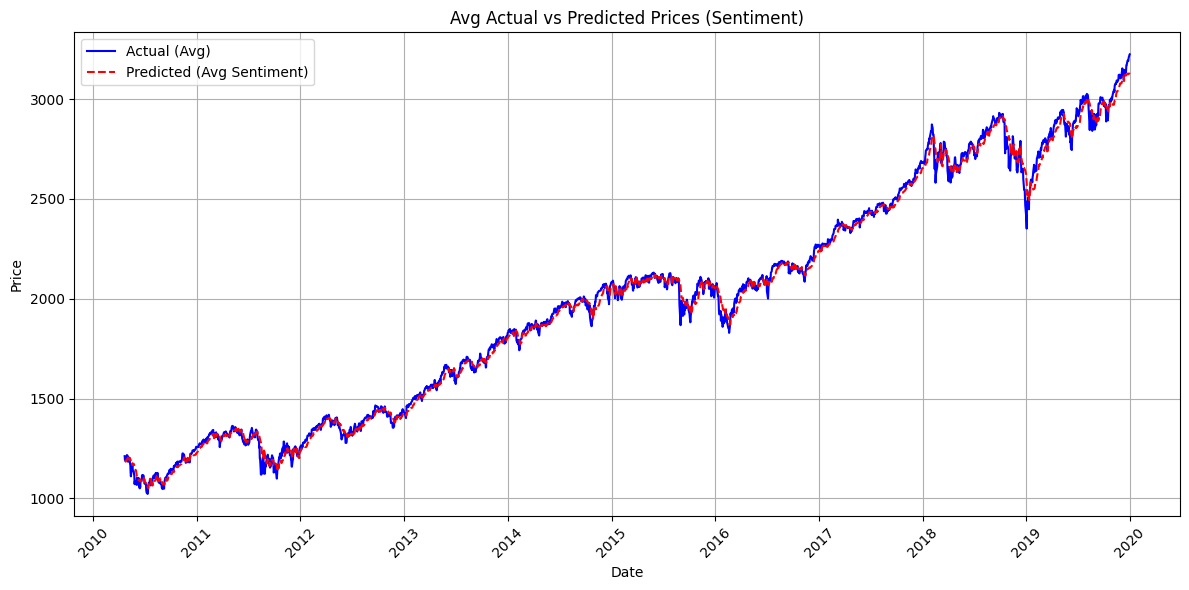

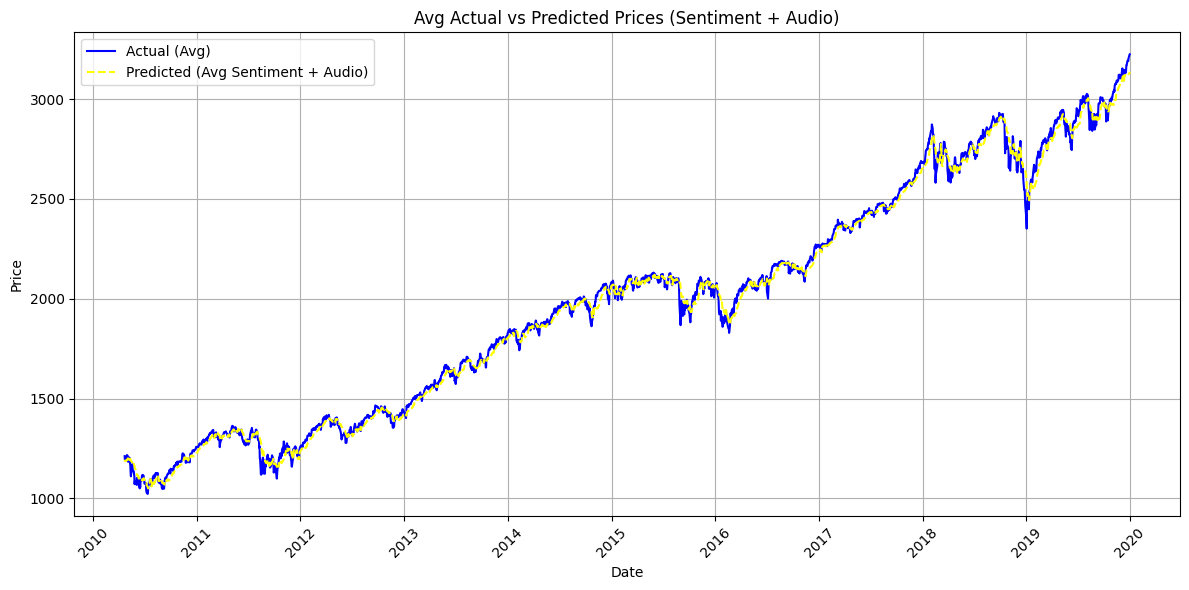

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Date is datetime and set as index
if 'Date' in df_merged.columns:
    df_merged['Date'] = pd.to_datetime(df_merged['Date'], errors='coerce')
    df_merged = df_merged.set_index('Date')

# Sort and clean index
df_merged = df_merged.sort_index()
df_merged.index = pd.to_datetime(df_merged.index, errors='coerce')

# Get the list of shared feature keys (like SMA, Sentiment, etc.)
feature_keys = list(stacked_results_no_audio.keys())

# Average predictions and actuals across all features
predictions_sentiment = np.mean(
    [stacked_results_no_audio[feature]['predictions'] for feature in feature_keys], axis=0
)
actuals_sentiment = np.mean(
    [stacked_results_no_audio[feature]['actual'] for feature in feature_keys], axis=0
)

feature_keys_audio = list(stacked_results_audio.keys())
predictions_audio = np.mean(
    [stacked_results_audio[feature]['predictions'] for feature in feature_keys_audio], axis=0
)
actuals_audio = np.mean(
    [stacked_results_audio[feature]['actual'] for feature in feature_keys_audio], axis=0
)

# Derive correct starting indices based on prediction lengths
start_idx_sentiment = len(df_merged) - len(predictions_sentiment)
start_idx_audio = len(df_merged) - len(predictions_audio)

# Slice dates from cleaned index
test_dates_sentiment = df_merged.index[start_idx_sentiment:]
test_dates_audio = df_merged.index[start_idx_audio:]

# Ensure the indexes are datetime (for safety)
test_dates_sentiment = pd.to_datetime(test_dates_sentiment)
test_dates_audio = pd.to_datetime(test_dates_audio)

# Plot 1: Sentiment Predictions
plt.figure(figsize=(12, 6))
plt.plot(test_dates_sentiment, actuals_sentiment, label='Actual (Avg)', color='blue')
plt.plot(test_dates_sentiment, predictions_sentiment, label='Predicted (Avg Sentiment)', color='red', linestyle='--')
plt.title('Avg Actual vs Predicted Prices (Sentiment)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Sentiment + Audio Predictions
plt.figure(figsize=(12, 6))
plt.plot(test_dates_audio, actuals_audio, label='Actual (Avg)', color='blue')
plt.plot(test_dates_audio, predictions_audio, label='Predicted (Avg Sentiment + Audio)', color='yellow', linestyle='--')
plt.title('Avg Actual vs Predicted Prices (Sentiment + Audio)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Testing

In [27]:
# Reset the index to make 'Date' a column before merging
df_reset = df_test.reset_index()

# Load the sentiment data files
daily_sentiment_audio_df = pd.read_csv("/content/drive/MyDrive/FYP/daily_sentiment_scores_w_audio.csv")
daily_sentiment_df = pd.read_csv("/content/drive/MyDrive/FYP/daily_sentiment_scores.csv")

# Ensure the sentiment data is sorted by date
daily_sentiment_audio_df['Date'] = pd.to_datetime(daily_sentiment_audio_df['Date'])
daily_sentiment_df['Date'] = pd.to_datetime(daily_sentiment_df['Date'])

# Merge the sentiment data with the stock data (df)
df_merged = pd.merge(df_reset, daily_sentiment_audio_df[['Date', 'Daily Sentiment Score (w/ Audio)']], on='Date', how='left')
df_merged = pd.merge(df_merged, daily_sentiment_df[['Date', 'Daily Sentiment Score']], on='Date', how='left')

# Forward and back fill only the two sentiment score columns
df_sentiment = df_merged.copy()
df_sentiment[['Daily Sentiment Score', 'Daily Sentiment Score (w/ Audio)']] = df_sentiment[
    ['Daily Sentiment Score', 'Daily Sentiment Score (w/ Audio)']
].ffill().bfill()

df_test_norm_audio = normalize_features(df_sentiment, indicators_without_audio)

In [28]:
# Test the model with the sentiment_audio feature
test_stacked_results_audio = train_rf_lstm_stacked_model(df_test_norm_audio, indicators_with_audio, ['Daily Sentiment Score (w/ Audio)'])
print("Stacked model results with sentiment audio:")
print(test_stacked_results_audio)

# Save results with sentiment_audio
with open('/content/drive/MyDrive/FYP/output/test_stacked_results_audio.pkl', 'wb') as f:
    pickle.dump(test_stacked_results_audio, f)


Processing Close_Shifted...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 167ms/step - loss: 9.1137 - val_loss: 8.6200
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - loss: 8.3401 - val_loss: 7.9632
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - loss: 7.7556 - val_loss: 7.4334
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 7.2170 - val_loss: 6.9789
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - loss: 6.7151 - val_loss: 6.4827
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - loss: 6.2451 - val_loss: 6.0510
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - loss: 5.8058 - val_loss: 5.6344
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 5.3977 - val_loss: 5.2591
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 5.0218 - val_loss: 4.8598
Epoch 10/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 4.6485 - val_loss: 4.5442
Epoch 11/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 4.3221 - val_loss: 4.2490
Epoch 12/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 4

Close_Shifted Stacked: 100%|██████████| 1236/1236 [02:19<00:00,  8.89it/s]



Processing RSI...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 174ms/step - loss: 9.1034 - val_loss: 8.6068
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - loss: 8.3226 - val_loss: 8.0307
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 7.7336 - val_loss: 7.4754
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - loss: 7.2007 - val_loss: 6.9314
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - loss: 6.7011 - val_loss: 6.4585
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - loss: 6.2288 - val_loss: 6.0551
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - loss: 5.7938 - val_loss: 5.6210
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - loss: 5.3875 - val_loss: 5.2559
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - loss: 4.9969 - val_loss: 4.8755
Epoch 10/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - loss: 4.6385 - val_loss: 4.5355
Epoch 11/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - loss: 4.3093 - val_loss: 4.2146
Epoch 12/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - loss: 4

RSI Stacked: 100%|██████████| 1236/1236 [02:21<00:00,  8.74it/s]



Processing MACD...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 162ms/step - loss: 9.0879 - val_loss: 8.6744
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 8.3419 - val_loss: 8.0370
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - loss: 7.7538 - val_loss: 7.4681
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - loss: 7.2134 - val_loss: 6.9529
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - loss: 6.7201 - val_loss: 6.5230
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 6.2522 - val_loss: 6.0504
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 5.8132 - val_loss: 5.6418
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 5.4024 - val_loss: 5.2675
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - loss: 5.0294 - val_loss: 4.9245
Epoch 10/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 4.6665 - val_loss: 4.5652
Epoch 11/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - loss: 4.3310 - val_loss: 4.2632
Epoch 12/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 4

MACD Stacked: 100%|██████████| 1236/1236 [02:21<00:00,  8.72it/s]



Processing Daily Sentiment Score (w/ Audio)...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 163ms/step - loss: 9.1109 - val_loss: 8.6356
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - loss: 8.3511 - val_loss: 8.0433
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - loss: 7.7637 - val_loss: 7.4852
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 7.2073 - val_loss: 6.9458
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - loss: 6.7068 - val_loss: 6.4782
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - loss: 6.2340 - val_loss: 6.0444
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 5.7943 - val_loss: 5.6363
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 5.3915 - val_loss: 5.2347
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - loss: 5.0003 - val_loss: 4.8638
Epoch 10/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - loss: 4.6406 - val_loss: 4.5568
Epoch 11/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - loss: 4.3022 - val_loss: 4.2365
Epoch 12/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - loss: 3

Daily Sentiment Score (w/ Audio) Stacked: 100%|██████████| 1236/1236 [02:23<00:00,  8.62it/s]


Time taken for stacked model with Close_Shifted, RSI, MACD, Daily Sentiment Score (w/ Audio): 859.1215288639069 seconds
Stacked model results with sentiment audio:
{'Close_Shifted': {'predictions': [1183.6595346117779, 1192.7813498186204, 1191.076241338527, 1192.8977058076246, 1194.5978080744937, 1196.9023486238018, 1198.3804213070277, 1203.859803180331, 1205.0662643767862, 1183.3672344486297, 1196.8824369624288, 1200.2489213253473, 1192.206175732927, 1200.5075471478344, 1195.701076527797, 1196.0824449779595, 1188.483432839269, 1183.9840822173342, 1181.8261312561228, 1170.4302135931919, 1175.9204268589756, 1167.1603478487207, 1172.4202239411884, 1167.4845961277492, 1162.2001734745966, 1156.5678934289995, 1147.0981238170784, 1142.4018067182203, 1125.7252023386454, 1117.4095393129096, 1119.6307415338567, 1110.047380601102, 1116.3356599675642, 1108.2541713084279, 1103.1970994887815, 1098.4538880483713, 1087.5338886453985, 1087.3288982078666, 1088.4832791538431, 1084.5375708573742, 1083.30

In [31]:
path = '/content/drive/MyDrive/FYP/output/test_stacked_results_audio.pkl'
model_name = 'Test Stacked (With Audio)'

df = evaluate_model_to_classification_table(path, model_name)

# Calculate averages
avg_metrics = df[['Accuracy', 'Precision', 'Recall', 'F1 Score']].mean()

print(f"{model_name} Evaluation (Averaged across indicators):")
for metric, value in avg_metrics.items():
    print(f"  {metric}: {value:.4f}")
print()

Test Stacked (With Audio) Evaluation (Averaged across indicators):
  Accuracy: 0.5233
  Precision: 0.5491
  Recall: 0.6314
  F1 Score: 0.5874



In [32]:
# Test the model with the sentiment_audio feature
test_stacked_results_no_audio = train_rf_lstm_stacked_model(df_test_norm_audio, indicators_without_audio, ['Daily Sentiment Score'])
print("Stacked model results with sentiment audio:")
print(test_stacked_results_no_audio)

# Save results with sentiment_audio
with open('/content/drive/MyDrive/FYP/output/test_stacked_results_no_audio.pkl', 'wb') as f:
    pickle.dump(test_stacked_results_audio, f)


Processing Close_Shifted...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - loss: 9.1064 - val_loss: 8.6203
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - loss: 8.3340 - val_loss: 7.9492
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - loss: 7.7545 - val_loss: 7.4358
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 7.2115 - val_loss: 6.9570
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - loss: 6.7029 - val_loss: 6.4576
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - loss: 6.2340 - val_loss: 6.0128
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 5.7866 - val_loss: 5.5975
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - loss: 5.3719 - val_loss: 5.2221
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - loss: 4.9903 - val_loss: 4.8939
Epoch 10/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - loss: 4.6349 - val_loss: 4.4932
Epoch 11/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - loss: 4.2996 - val_loss: 4.2117
Epoch 12/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - loss: 3

Close_Shifted Stacked: 100%|██████████| 1236/1236 [02:26<00:00,  8.44it/s]



Processing RSI...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 164ms/step - loss: 9.1111 - val_loss: 8.6880
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 8.3556 - val_loss: 8.0671
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 7.7608 - val_loss: 7.4933
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 7.2165 - val_loss: 6.9840
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - loss: 6.7121 - val_loss: 6.4815
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - loss: 6.2462 - val_loss: 6.0357
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - loss: 5.7969 - val_loss: 5.6434
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 5.3838 - val_loss: 5.2594
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - loss: 4.9981 - val_loss: 4.8591
Epoch 10/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - loss: 4.6517 - val_loss: 4.5275
Epoch 11/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - loss: 4.3149 - val_loss: 4.2270
Epoch 12/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - loss: 3

RSI Stacked: 100%|██████████| 1236/1236 [02:24<00:00,  8.54it/s]



Processing MACD...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - loss: 9.0971 - val_loss: 8.6787
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - loss: 8.3335 - val_loss: 8.0755
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 7.7504 - val_loss: 7.4910
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - loss: 7.2098 - val_loss: 6.9703
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - loss: 6.7100 - val_loss: 6.4888
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - loss: 6.2286 - val_loss: 6.0554
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - loss: 5.8000 - val_loss: 5.6438
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - loss: 5.3862 - val_loss: 5.2523
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 5.0025 - val_loss: 4.8917
Epoch 10/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - loss: 4.6446 - val_loss: 4.5358
Epoch 11/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - loss: 4.3128 - val_loss: 4.2247
Epoch 12/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 4

MACD Stacked: 100%|██████████| 1236/1236 [02:23<00:00,  8.63it/s]



Processing Daily Sentiment Score...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 170ms/step - loss: 9.0842 - val_loss: 8.7060
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - loss: 8.3430 - val_loss: 8.0358
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 7.7555 - val_loss: 7.4232
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - loss: 7.2081 - val_loss: 6.9429
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - loss: 6.7130 - val_loss: 6.4851
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - loss: 6.2414 - val_loss: 6.0462
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - loss: 5.8011 - val_loss: 5.6070
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - loss: 5.3873 - val_loss: 5.2390
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - loss: 4.9985 - val_loss: 4.9059
Epoch 10/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - loss: 4.6419 - val_loss: 4.5102
Epoch 11/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 4.3137 - val_loss: 4.2217
Epoch 12/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - loss: 3

Daily Sentiment Score Stacked: 100%|██████████| 1236/1236 [02:31<00:00,  8.17it/s]


Time taken for stacked model with Close_Shifted, RSI, MACD, Daily Sentiment Score: 888.6970272064209 seconds
Stacked model results with sentiment audio:
{'Close_Shifted': {'predictions': [3297.3951023781365, 3256.89095060272, 3260.3393805983783, 3296.6857864987933, 3308.7239436203085, 3312.4935438238886, 3320.766692001981, 3325.997963476591, 3331.806991115935, 3337.4726193732217, 3335.33584507407, 3351.1887571767966, 3344.7421239304863, 3338.295748476513, 3340.9000148303667, 3329.5748006497893, 3270.0136321525342, 3250.9978696539465, 3240.0274634300345, 3219.3210652261423, 3169.267206953745, 3167.904121302417, 3183.489353081001, 3166.9146012581173, 3177.7519396837615, 3149.7574313094224, 3122.215884906561, 3115.1821497353912, 3075.7561871940184, 3041.5873540462358, 3003.2114121004497, 2875.8269047719773, 2836.8760983526026, 2833.0464444757986, 2751.0078609147654, 2652.679566908741, 2520.507873689173, 2511.1789177574997, 2483.0364911812994, 2535.017669856095, 2514.68547635199, 2558.0220

In [33]:
path = '/content/drive/MyDrive/FYP/output/test_stacked_results_no_audio.pkl'
model_name = 'Test Stacked (No Audio)'

df = evaluate_model_to_classification_table(path, model_name)

# Calculate averages
avg_metrics = df[['Accuracy', 'Precision', 'Recall', 'F1 Score']].mean()

print(f"{model_name} Evaluation (Averaged across indicators):")
for metric, value in avg_metrics.items():
    print(f"  {metric}: {value:.4f}")
print()

Test Stacked (No Audio) Evaluation (Averaged across indicators):
  Accuracy: 0.5233
  Precision: 0.5491
  Recall: 0.6314
  F1 Score: 0.5874



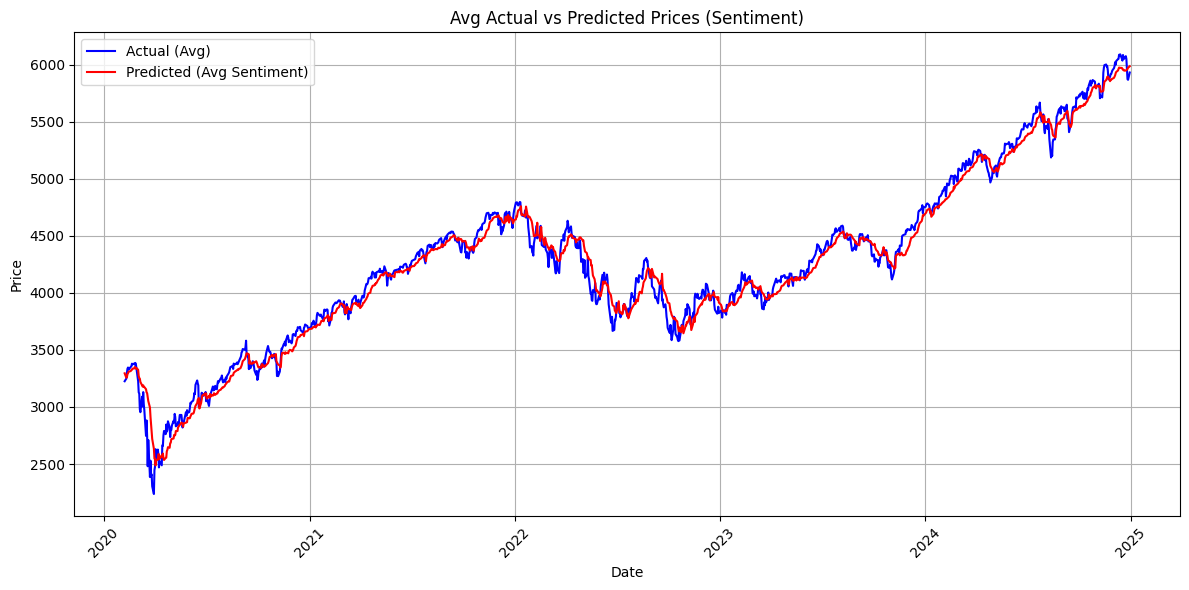

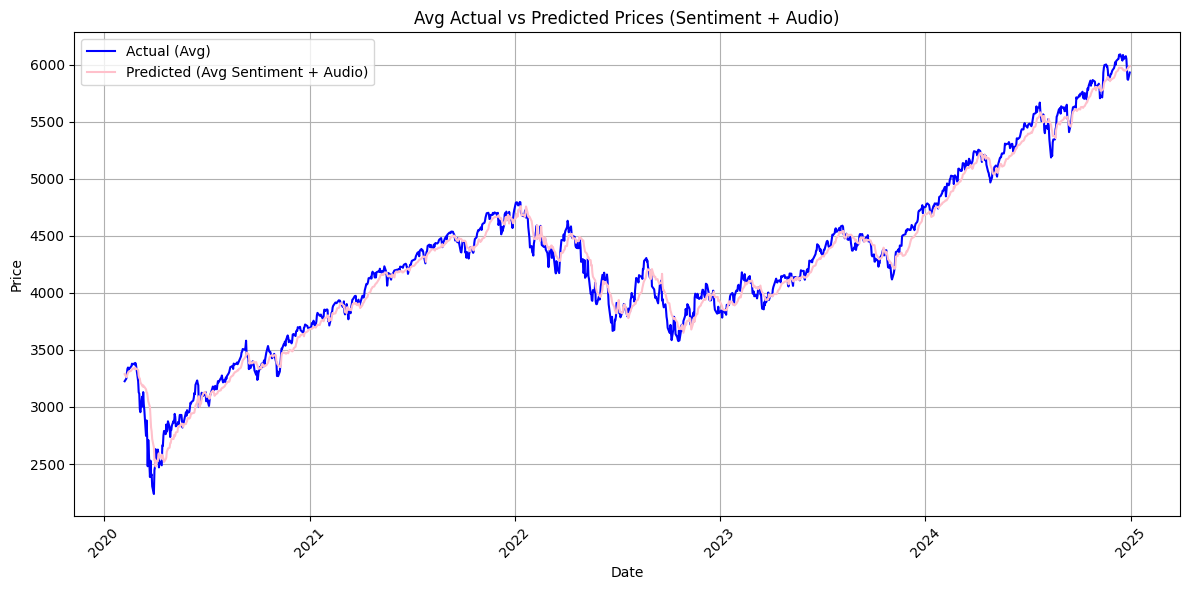

In [36]:
# Ensure Date is datetime and set as index
if 'Date' in df_merged.columns:
    df_merged['Date'] = pd.to_datetime(df_merged['Date'], errors='coerce')
    df_merged = df_merged.set_index('Date')

# Sort and clean index
df_merged = df_merged.sort_index()
df_merged.index = pd.to_datetime(df_merged.index, errors='coerce')

# Get the list of shared feature keys (like SMA, Sentiment, etc.)
feature_keys = list(test_stacked_results_no_audio.keys())

# Average predictions and actuals across all features
predictions_sentiment = np.mean(
    [test_stacked_results_no_audio[feature]['predictions'] for feature in feature_keys], axis=0
)
actuals_sentiment = np.mean(
    [test_stacked_results_no_audio[feature]['actual'] for feature in feature_keys], axis=0
)

feature_keys_audio = list(test_stacked_results_audio.keys())
predictions_audio = np.mean(
    [test_stacked_results_audio[feature]['predictions'] for feature in feature_keys_audio], axis=0
)
actuals_audio = np.mean(
    [test_stacked_results_audio[feature]['actual'] for feature in feature_keys_audio], axis=0
)

# Derive correct starting indices based on prediction lengths
start_idx_sentiment = len(df_merged) - len(predictions_sentiment)
start_idx_audio = len(df_merged) - len(predictions_audio)

# Slice dates from cleaned index
test_dates_sentiment = df_merged.index[start_idx_sentiment:]
test_dates_audio = df_merged.index[start_idx_audio:]

# Ensure the indexes are datetime (for safety)
test_dates_sentiment = pd.to_datetime(test_dates_sentiment)
test_dates_audio = pd.to_datetime(test_dates_audio)

# Plot 1: Sentiment Predictions
plt.figure(figsize=(12, 6))
plt.plot(test_dates_sentiment, actuals_sentiment, label='Actual (Avg)', color='blue')
plt.plot(test_dates_sentiment, predictions_sentiment, label='Predicted (Avg Sentiment)', color='red', linestyle='-')
plt.title('Avg Actual vs Predicted Prices (Sentiment)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Sentiment + Audio Predictions
plt.figure(figsize=(12, 6))
plt.plot(test_dates_audio, actuals_audio, label='Actual (Avg)', color='blue')
plt.plot(test_dates_audio, predictions_audio, label='Predicted (Avg Sentiment + Audio)', color='pink', linestyle='-')
plt.title('Avg Actual vs Predicted Prices (Sentiment + Audio)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
# Calculate MAE for models with sentiment analysis (with audio)
df_test_stack_with_audio = summarize_mae(test_stacked_results_audio, "RF+LSTM (With Audio)")
# Calculate MAE for models with sentiment analysis (without audio)
df_test_stack_no_audio = summarize_mae(test_stacked_results_no_audio, "RF+LSTM (No Audio)")

# Merge the results for side-by-side comparison
comparison_df = df_test_stack_with_audio.merge(df_stack_no_audio, on="Indicator")

# Print out the comparison of the two models
print("Comparison of models:")
print(comparison_df.round(4))

# Sort by Test MAE to find the best indicators for both models
best_indicators_test = comparison_df.sort_values(by=["RF+LSTM (With Audio)_Test_MAE", "RF+LSTM (No Audio)_Test_MAE"]).reset_index(drop=True)

# Get top 3 indicators based on Test MAE for both models
top_3_indicators_test = best_indicators_test.head(3)

# Display the top 3 indicators based on Test MAE
print("\nTop 3 best indicators based on Test MAE:")
print(top_3_indicators_test.round(4))

Comparison of models:
       Indicator  RF+LSTM (With Audio)_Train_MAE  \
0  Close_Shifted                         33.2614   
1            RSI                         33.0305   
2           MACD                         33.5282   

   RF+LSTM (With Audio)_Test_MAE  RF+LSTM (No Audio)_Train_MAE  \
0                        74.5103                       11.5544   
1                        72.6672                       11.3696   
2                        74.3772                       11.5656   

   RF+LSTM (No Audio)_Test_MAE  
0                      24.6022  
1                      24.5193  
2                      24.8099  

Top 3 best indicators based on Test MAE:
       Indicator  RF+LSTM (With Audio)_Train_MAE  \
0            RSI                         33.0305   
1           MACD                         33.5282   
2  Close_Shifted                         33.2614   

   RF+LSTM (With Audio)_Test_MAE  RF+LSTM (No Audio)_Train_MAE  \
0                        72.6672                       